# Remote Work and Wage Inequality: Correcting Bias in Regression with Generated Binary Labels

This notebook estimates the association between working from home and salaries using real-world job postings data [(Hansen et al., 2023)](https://dx.doi.org/10.2139/ssrn.4380734). It illustrates how the functions `ols_bca`, `ols_bcm` and `one_step` can be used to correct bias from regressing on AI/ML-generated labels. The notebook reproduces results from Table 1 of [Battaglia, Christensen, Hansen & Sacher (2024)](https://arxiv.org/abs/2402.15585).

In [1]:
from ValidMLInference import ols, ols_bcm, remote_work_data, one_step_gaussian_mixture
import numpy as np

## Data

The package contains a subset of [a larger dataset](https://wfhmap.com/) regarding work from home. The sample consists of 16,315 job postings for 2022 and 2023 with “San Diego, CA” recorded as the city and “72” recorded as the NAICS2 industry code of the advertising firm. 

The data set contains the following entries:
1. `city_name` 
2. `naics_2022_2` - an industry code 
3. `salary` 
4. `wfh_wham` - ML-generated indicator of whether the job offers work from home using fine-tuned DistilBERT as in [(Hansen et al., 2023)](https://dx.doi.org/10.2139/ssrn.4380734)
5. `soc_2021_2` - Bureau of Labor Statistics Standard Occupational Classification code
6. `employment_type_name` - indicates whether the position is full-time or part-time 

In [2]:
SD_data = remote_work_data()
SD_data.head(5)

,Unnamed: 0,city_name,naics_2022_2,id,salary,wfh_wham,soc_2021_2,employment_type_name
0,1,"San Diego, CA",72,002e22ebe1b837ac6b0cebcbb720613138765f51,57500.0,0,11-0000,Full-time (> 32 hours)
1,2,"San Diego, CA",72,00442454060b60c1c0ad4ed78bc29111935f400b,31200.0,0,35-0000,Full-time (> 32 hours)
2,3,"San Diego, CA",72,007a1c1a527ed15006705379cec780aaae4930af,33280.0,0,35-0000,Part-time / full-time
3,4,"San Diego, CA",72,00991b69215b1cc14c08c4cdfa1b10bbbdf6ceba,40560.0,0,35-0000,Full-time (> 32 hours)
4,5,"San Diego, CA",72,00edf6dc0abb731a0befa73f6748ff3f5ce842f4,45760.0,0,11-0000,Full-time (> 32 hours)


For purpose of this estimation, we also log-transform the salary data. 

In [3]:
SD_data['salary'] = np.log(SD_data['salary'])

## Estimating the false-positive rate

The variable `wfh_wham` describing whether the job posting offers remote work is not manually collected, but is imputed via ML methods using fine-tuned DistilBERT as in [(Hansen et al., 2023)](https://dx.doi.org/10.2139/ssrn.4380734). This classifier has over 99% test accuracy in the full sample. Nevertheless, as [Battaglia, Christensen, Hansen & Sacher (2024)](https://arxiv.org/abs/2402.15585) document, even high-performance classifiers can lead to large biases in OLS estimates.

The bias correction methods `ols_bca` and `ols_bcm` require estimates of the classifier's false-positive rate.

We estimate the false positive rate manually. To do so, we took a random sample of size 1000 postings. Of these, 26 had `wfh_wham = 1`. Based on reading these 26 postings, 9 appeared to be misclassified. This means the estimated false-positive rate is 0.009. Accordingly, we will implement `ols_bcm` with `fpr = 0.009` (the estimated false-positive rate) and `m = 1000` (the sample size used to estimate the false-positive rate).

## Results

We first present results for a simple regression of log salary onto the remote work indicator. We then consider a second specification with fixed effects.

We compare standard OLS esitmates and confidence intervals with estimates and confidence intervals using `ols_bcm` which performs a direct bias correction and computes bias corrected CIs, and `one_step` which performs maximum likelihood estimation treating the true labels as latent.

### Without fixed effects

We first present OLS estimates:

In [11]:
res = ols(formula = "salary ~ wfh_wham", data=SD_data, intercept = True)
print(res.summary())

            Estimate  Std. Error      z value  P>|z|       2.5%      97.5%
Intercept  10.655967    0.002589  4115.094402    0.0  10.650891  10.661042
wfh_wham    0.648514    0.024911    26.033376    0.0   0.599690   0.697339


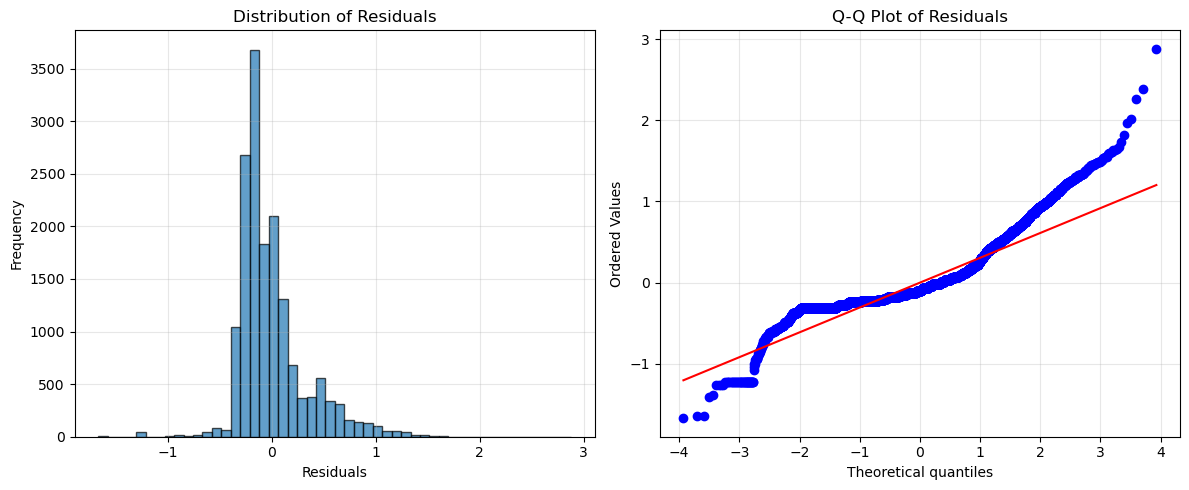

Mean of residuals: -0.000000
Standard deviation: 0.331642
Skewness: 1.458137
Kurtosis: 3.983987


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the fitted values and calculate residuals manually

y = SD_data['salary'].values
X = np.column_stack([np.ones(len(SD_data)), SD_data['wfh_wham'].values])

# Get the fitted values using the coefficients from our result
fitted_values = X @ res.coef

# Calculate residuals
residuals = y - fitted_values

# Now plot the distribution of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of residuals
ax1.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Residuals')
ax1.grid(True, alpha=0.3)

# Q-Q plot to check normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot of Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Mean of residuals: {residuals.mean():.6f}")
print(f"Standard deviation: {residuals.std():.6f}")
print(f"Skewness: {stats.skew(residuals):.6f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.6f}")

Now using the multiplicative bias correction, with bias corrected CIs:

In [9]:
res = ols_bcm(formula= "salary ~ wfh_wham", data=SD_data, fpr = 0.009, m = 1000, intercept=True)
print(res.summary())

            Estimate  Std. Error      z value         P>|z|       2.5%  \
wfh_wham    1.052442    0.140035     7.515553  5.662137e-14   0.777978   
Intercept  10.646261    0.004174  2550.611816  0.000000e+00  10.638081   

               97.5%  
wfh_wham    1.326906  
Intercept  10.654442  


Finally, using maximum likelihood:

In [6]:
res = one_step_gaussian_mixture(formula = "salary ~ wfh_wham", data = SD_data, generated_var = "wfh_wham", k = 3, nguess = 30, maxiter=300, seed = 123) 
print(res.summary())

            Estimate  Std. Error      z value  P>|z|       2.5%      97.5%
Intercept  10.543756    0.001812  5818.739746    0.0  10.540204  10.547307
wfh_wham    0.557184    0.011078    50.295826    0.0   0.535472   0.578897


### With fixed effects

We repeat the above now with fixed effects, which are easily generated for the categorical variables `soc_2021_2` and `employment_type_name`.

First using OLS:

In [7]:
res = ols(formula = "salary ~ wfh_wham + C(soc_2021_2) + C(employment_type_name)", data = SD_data, intercept=True)
summary = res.summary()
rows = ["Intercept", "wfh_wham"]
print(summary.loc[rows])

            Estimate  Std. Error      z value  P>|z|       2.5%      97.5%
Intercept  11.088260    0.009039  1226.680057    0.0  11.070543  11.105977
wfh_wham    0.363921    0.021544    16.892263    0.0   0.321696   0.406146


Now using the multiplicative bias correction:

In [8]:
res = ols_bcm(formula = "salary ~ wfh_wham + C(soc_2021_2) + C(employment_type_name)", generated_var = "wfh_wham", data = SD_data, fpr = 0.009, m=1000)
summary = res.summary()
print(summary.loc[rows])

            Estimate  Std. Error      z value         P>|z|       2.5%  \
Intercept  11.074074    0.010335  1071.556274  0.000000e+00  11.053819   
wfh_wham    0.641276    0.099605     6.438210  1.208906e-10   0.446054   

               97.5%  
Intercept  11.094329  
wfh_wham    0.836497  


Comparing these results with the OLS results above, we see that the bias corrected CI for the slope coefficient lies to the right of the OLS CI.

Finally, using maximum likelihood:

In [10]:
res = one_step_gaussian_mixture(formula = "salary ~ wfh_wham + C(soc_2021_2) + C(employment_type_name)", data = SD_data, generated_var = "wfh_wham", k = 3, nguess = 30, maxiter=300) 
summary = res.summary()
print(summary.loc[rows])

            Estimate  Std. Error      z value  P>|z|       2.5%      97.5%
Intercept  10.889956    0.007921  1374.768799    0.0  10.874430  10.905481
wfh_wham    0.508565    0.015730    32.330315    0.0   0.477734   0.539395
